# Домашнее задание

Создание тг-бота с LLM

**Цель:**

В данном домашнем задании вы создадите телеграм-ботов и интегрируете свои модели в телеграм-ботов.

### Описание / Пошаговая инструкция выполнения домашнего задания:

1. Возьмите ОДНУ из задач, с которой вы работали на курсе (например, задачу sentiment analysis или задачу из бенчмарка ruMTEB).

2. Зафайнтьюньте модель с сайта Huggingface для выбранной задачи (например, энкодерную модель, такую как ruBERT, или энкодер-декодерную модель, такую как ruT5). В случае если вы берёте задачу для sentence-transformer и задачу из бенчмарка ruMTEB, необходимо написать pipeline применения модели для задачи и её решения, как в ДЗ про sentence-transformer.

3. Создайте телеграм-бота, в котором будет поднята эта модель. Бот должен вначале писать вводное сообщение с описанием задачи, обрабатывать запрос пользователя и выводить ответ для заданного пользователем примера.

In [15]:
import random
import time
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig  
from transformers import get_linear_schedule_with_warmup

import requests
import telebot
from telebot import types

import warnings
warnings.filterwarnings("ignore")

# 1. Выбор задачи и модели

В качестве набора данных я выбрал "Yes/no Question Answering Dataset for the Russian" бенчмарка [Russian SuperGLUE](https://russiansuperglue.com/tasks/). Набор данных содержит пары текстовых фрагментов, в частности, контекст и вопрос, а от модели ожидается ответ Да или Нет. Соответственно, решаем задачу бинарной классификации, а в качестве модели возьмем ruBert-base из репозитория ai-forever

In [2]:
model_ckpt = "ai-forever/ruBert-base"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
tokenizer = BertTokenizer.from_pretrained(model_ckpt, do_lower_case=True)
tokenizer

BertTokenizer(name_or_path='ai-forever/ruBert-base', vocab_size=120138, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [5]:
model = BertForSequenceClassification.from_pretrained(
    model_ckpt, 
    num_labels = 2, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [6]:
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate) 

In [7]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)

In [8]:
def load_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)
    return np.array(input_ids), np.array(attention_masks)

### Загружаем данные для обучения и валидации из датасета [Russian SuperGLUE](https://russiansuperglue.com/tasks/)

In [9]:
train_data_df = pd.read_json('./data/DaNetQA/train.jsonl', lines=True)
train_data_df.head()

,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4


In [10]:
dev_data_df = pd.read_json('./data/DaNetQA/val.jsonl', lines=True)
dev_data_df.head()

,question,passage,label,idx
0,Есть ли вода на марсе?,Гидросфера Марса — это совокупность водных зап...,True,0
1,Состоит ли англия в евросоюзе?,В полночь с 31 января на 1 февраля 2020 года п...,False,1
2,Действительно ли в ссср не было адвокатов?,Семён Львович Ария — советский и российский ю...,False,2
3,Была ли чума в оране?,"Чума — это и абсурд, что осмысливается как фор...",True,3
4,Был ли кетчуп в читосе?,Текущий каталог продукции размещен на сайте пр...,True,4


In [11]:
passages_train = train_data_df.passage.values
questions_train = train_data_df.question.values
answers_train = train_data_df.label.values.astype(int)
print(answers_train)

passages_dev = dev_data_df.passage.values
questions_dev = dev_data_df.question.values
answers_dev = dev_data_df.label.values.astype(int)

# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = load_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = load_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[1 1 1 ... 1 0 1]


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [12]:
# Building Dataloaders
batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

Предобработка данных завершена, переходим к обучению модели

## 2. Fine tuning ruBert-base

In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
# Number of EPOCHS
EPOCHS = 10
total_steps = len(train_dataloader) * EPOCHS
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [15]:
def accuracy(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [16]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

train_losses_history = []
val_losses_history = []

#for _ in tqdm(range(epochs), desc="Epoch"):
for epoch in range(EPOCHS):

  # Training
  model.train()

  # Reset the total loss and accuracy for this epoch.
  total_train_loss = 0
  total_train_acc = 0
  
  # Measure how long the training epoch takes.
  start = time.time()

  for step, batch in enumerate(train_dataloader):
      # Unpack this training batch from our dataloader.
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device)  

      #clear any previously calculated gradients before performing a backward pass
      optimizer.zero_grad()

      #result = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)
      loss, prediction = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels).values()
      #loss = result.loss
      #logits = result.logits
      acc = accuracy(prediction, labels)

      # Accumulate the training loss and accuracy over all of the batches so that we can
      # calculate the average loss at the end
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      # Update the learning rate.
      scheduler.step()

  # Calculate the average accuracy and loss over all of the batches.
  train_acc  = total_train_acc/len(train_dataloader)
  train_loss = total_train_loss/len(train_dataloader)
  train_losses_history.append(train_loss)

  # Put the model in evaluation mode
  model.eval()

  total_val_acc  = 0
  total_val_loss = 0

  with torch.no_grad():
    for batch in dev_dataloader:

      #clear any previously calculated gradients before performing a backward pass
      optimizer.zero_grad()

      # Unpack this validation batch from our dataloader.
      input_ids = batch[0].to(device)
      attention_masks = batch[1].to(device)
      labels = batch[2].to(device) 

      #Get the loss and prediction
      loss, prediction = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels).values()

      # Calculate the accuracy for this batch
      acc = accuracy(prediction, labels)

      # Accumulate the validation loss and Accuracy
      total_val_loss += loss.item()
      total_val_acc  += acc.item()

  # Calculate the average accuracy and loss over all of the batches.
  val_acc  = total_val_acc/len(dev_dataloader)
  val_loss = total_val_loss/len(dev_dataloader)
  val_losses_history.append(val_loss)

  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  #save the best model
  if val_loss < best_eval_loss:
      best_eval_loss = val_loss
      torch.save(model.state_dict(), 'ruBert_saved_weights.pt')     

Epoch 1: train_loss: 0.6072 train_acc: 0.6792 | val_loss: 0.7577 val_acc: 0.5773
00:00:09.76
Epoch 2: train_loss: 0.4637 train_acc: 0.7994 | val_loss: 0.9792 val_acc: 0.5545
00:00:09.68
Epoch 3: train_loss: 0.3152 train_acc: 0.8744 | val_loss: 0.7323 val_acc: 0.6321
00:00:09.63
Epoch 4: train_loss: 0.1767 train_acc: 0.9361 | val_loss: 0.9673 val_acc: 0.6338
00:00:09.65
Epoch 5: train_loss: 0.0938 train_acc: 0.9736 | val_loss: 1.1653 val_acc: 0.6489
00:00:09.67
Epoch 6: train_loss: 0.0654 train_acc: 0.9784 | val_loss: 1.4057 val_acc: 0.6513
00:00:09.66
Epoch 7: train_loss: 0.0327 train_acc: 0.9892 | val_loss: 1.6646 val_acc: 0.6344
00:00:09.68
Epoch 8: train_loss: 0.0237 train_acc: 0.9923 | val_loss: 1.6828 val_acc: 0.6573
00:00:09.67
Epoch 9: train_loss: 0.0171 train_acc: 0.9949 | val_loss: 1.8685 val_acc: 0.6399
00:00:09.63
Epoch 10: train_loss: 0.0110 train_acc: 0.9966 | val_loss: 1.8901 val_acc: 0.6435
00:00:09.65


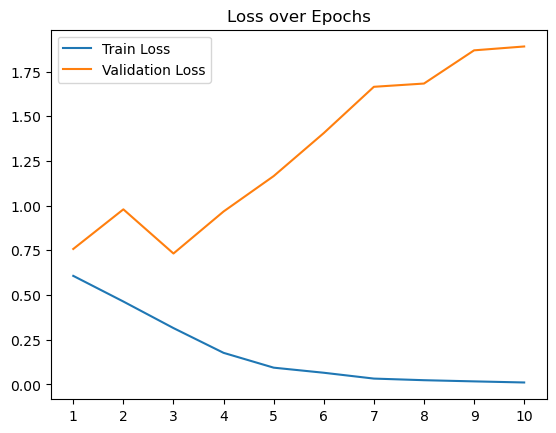

In [17]:
plt.title('Loss over Epochs')
plt.plot(np.arange(1,EPOCHS+1), train_losses_history, label='Train Loss')
plt.plot(np.arange(1,EPOCHS+1), val_losses_history, label='Validation Loss')
plt.xticks(np.arange(1,EPOCHS+1))
plt.legend()
plt.show();

In [18]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
#loading the best saved model
path = 'ruBert_saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [20]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

### Проверим на тестовых данных, что предсказывает модель

In [21]:
# Load Test data
test_data_df = pd.read_json('./data/DaNetQA/test.jsonl', lines=True)
test_data_df.head()

,question,passage,idx
0,Полезна ли ртуть с градусника?,"Отравления ртутью — расстройства здоровья, св...",0
1,Являются ли сапрофаги хищниками?,Фауна лесных почв — совокупность видов животны...,1
2,Водятся ли в индии крокодилы?,"Болотный крокодил, или магер — пресмыкающееся...",2
3,Есть ли в батате крахмал?,"Клубневидно вздутые корни весят до 15 кг, сод...",3
4,Был ли человек в железной маске?,Остров Сент-Маргерит — крупнейший из Лерински...,4


In [22]:
passage_list = test_data_df['passage'].to_list()
question_list = test_data_df['question'].to_list()

In [23]:
# Predict the answer
def predict(question, passage):
  sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)
  logits = model(sequence)[0]
  probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
  proba_yes = round(probabilities[1], 3)
  proba_no = round(probabilities[0], 3)
  print(f"Question: {question}, True: {proba_yes}, False: {proba_no}")
  return f"True: {proba_yes}, False: {proba_no}"  

In [24]:
sample_ids = random.sample(range(1, len(question_list)), 10)

#for i in range(1,11):
for i in sample_ids:
    question = question_list[i]
    passage = passage_list[i]
    predict(question,passage)

Question: Существует ли в российской федерации своя платежная система?, True: 0.22, False: 0.78
Question: Вредно ли пить витамин д?, True: 0.526, False: 0.474
Question: Были ли ассасины выдумкой?, True: 0.766, False: 0.234
Question: Входит ли в понятие информационной безопасности организация противоправного изменения информации?, True: 0.487, False: 0.513
Question: Правда ли были динозавры?, True: 0.915, False: 0.085
Question: Входит ли швейцария в нато?, True: 0.028, False: 0.972
Question: Правда ли что зарплата не входит в себестоимость?, True: 0.642, False: 0.358
Question: Разрешено ли в америке двойное гражданство?, True: 0.439, False: 0.561
Question: Состоит ли грузия в нато?, True: 0.119, False: 0.881
Question: Все ли брахманы запрещают есть рыбу?, True: 0.257, False: 0.743


## 3. Telegram Bot

In [3]:
path2token = './OracleBiBot_token.txt'

In [5]:
with open(path2token) as f:
    TOKEN = f.read().strip()

In [7]:
def make_bot_url(path):
    with open(path) as f:
        TOKEN = f.read().strip()
    bot_url = f'https://api.telegram.org/bot{TOKEN}'
    return bot_url

In [9]:
def send_message(text: str, channel_id: int, reply_to: int=None, reply_markup: dict=None):
    """text: string of any length
       channel_id: int - chat id
       reply_to: int message to reply id
       reply_markup: dict {inline_keyboard: [[{ text: 'Stop', callback_data: "string" }]],}
       return: list of response objects. res[0].status_code, res[0].json()
    """
    
    method = make_bot_url(path2token) + "/sendMessage"

    res = []
    if len(text) > 4096:
        for x in range(0, len(text), 4096):
            text_ = text[x:x + 4096]
            data = {
                "chat_id": channel_id,
                "text": text_
            }
            
            if reply_to:
                data['reply_to_message_id'] = reply_to

            r = requests.post(method, data=data)
            res.append(r)
    else:
        data = {
            "chat_id": channel_id,
            "text": text
        }
        
        if reply_markup:
            assert type(reply_markup) == dict
            data['reply_markup'] = json.dumps(reply_markup)
        
        if reply_to:
            data['reply_to_message_id'] = reply_to

        r = requests.post(method, data=data)
        res.append(r)

    return res

In [11]:
text = 'I am binary oracle bot'
my_chat_id = 406137873

In [17]:
r = send_message(text=text, channel_id=my_chat_id)
r

[<Response [200]>]

In [19]:
url = f'https://api.telegram.org/bot{TOKEN}' + "/getMe"

In [21]:
resp = requests.get(url)

In [23]:
resp.json()

{'ok': True,
 'result': {'id': 7662060530,
  'is_bot': True,
  'first_name': 'OracleBI',
  'username': 'OracleBiBot',
  'can_join_groups': True,
  'can_read_all_group_messages': False,
  'supports_inline_queries': False,
  'can_connect_to_business': False,
  'has_main_web_app': False}}

In [25]:
welcome_message = 'Вас приветствует бот, обученный давать бинарные ответы\nОпишите контекст, задайте вопрос с новой строки - и вы получите ответ:'

In [27]:
bot = telebot.TeleBot(TOKEN)

In [29]:
@bot.message_handler(commands=['start'])
def start_message(message):
    bot.send_message(message.chat.id, welcome_message)

@bot.message_handler(func=lambda x: True, chat_types=["private"])
def start_message(message):
    print(message.text)
    #bot.send_message(message.chat.id, "<b>Any other</b> <i>handler</i>", parse_mode="HTML")
    splits = message.text.split(sep="\n", maxsplit=1)
    print(f"C: {splits[0].strip()}")
    print(f"Q: {splits[1].strip()}")
    answer = predict(splits[1].strip(), splits[0].strip())
    print(answer)
    bot.send_message(message.chat.id, f"<b>Ответ на вопрос: {splits[1].strip()}</b>\n<i>{answer}</i>", parse_mode="HTML")

bot.infinity_polling()

2025-09-27 16:26:04,426 (__init__.py:1121 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
2025-09-27 16:26:04,426 (__init__.py:1123 MainThread) ERROR - TeleBot: "Break infinity polling"


## Bot Screenshots

![](./img/screenshot-disel.png)

![](./img/screenshot-nato.png)